# Neural Modelling: Assignment 5
## Learning to Act
### Submission Group: Luca Kosina (6084778), Sascha Mühlinghaus (7075485)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (5, 7)

# define goal (we abuse function scoping a bit here, later we will change the goal, which will automatically change the goal in our actor critic as well)
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10

def plot_maze(maze):
    plt.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plt.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plt.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)

    plt.xticks([])
    plt.yticks([])

In [3]:
def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # check if state is valid
            if maze[i, j] == 0:
                # iterate over all possible moves
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    # check if new state is valid
                    if new_i >= 0 and new_i < maze.shape[0] and new_j >= 0 and new_j < maze.shape[1] and maze[new_i, new_j] == 0:
                        transitions[i*maze.shape[1] + j, new_i*maze.shape[1] + new_j] = 1
    
    # normalize transitions
    transitions /= transitions.sum(axis=1, keepdims=True)

    # remove NaNs
    transitions[np.isnan(transitions)] = 0

    return transitions

transitions = compute_transition_matrix(maze)

def analytical_sr(transitions, gamma):
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions.T)

i, j = start


/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_901/1743974234.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)


In [4]:
# Part 1: program an actor critic algorithm to navigate the maze, using a table of action propensities M with softmax action selection as actor, and a learned state-value function as critic

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def normal_start():
    # suggested encoding of 2D location onto states
    state = start[0]*maze.shape[1] + start[1]
    return state

def get_valid_actions(state): 
    # find steps which do not go beyong maze boundaries or hit a wall
    i, j = divmod(state, maze.shape[1])
    actions = []
    moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for idx, move in enumerate(moves):
        new_i, new_j = i + move[0], j + move[1]
        if 0 <= new_i < maze.shape[0] and 0 <= new_j < maze.shape[1] and maze[new_i, new_j] == 0:
            actions.append(idx)
    return actions

def set_invalid_actions_to_zero(M, state, valid_actions): 
    # exclude all steps which go beyong maze boundaries or hit a wall
    ms = M[state]
    for i in range(len(ms)):
        if i not in valid_actions:
            ms[i] = 0
    return ms

def remove_invalid_actions(action_probs, valid_actions): 
    # exclude all steps which go beyong maze boundaries or hit a wall
    for i in range(len(action_probs)):
        if i not in valid_actions:
            action_probs[i] = 0
    action_probs /= action_probs.sum()  # Normalize
    return action_probs



In [5]:
# Function to learn SR from a trajectory
def learn_from_traj(state_representation, trajectory, alpha_sr=0.05, gamma_sr=0.98):
    """
    Updates the Successor Representation (SR) matrix from a given trajectory.
    
    Args:
        state_representation (ndarray): Current SR matrix of shape (n_states, n_states).
        trajectory (list): Sequence of states visited during an episode.
        alpha_sr (float): Learning rate for SR updates.
        gamma_sr (float): Discount factor for SR updates.
    """
    for state in trajectory:
        next_state = trajectory[trajectory.index(state) + 1] if trajectory.index(state) + 1 < len(trajectory) else None
        if next_state is not None:
            state_representation[state] += alpha_sr * (
                np.eye(state_representation.shape[0])[state]
                + gamma_sr * state_representation[next_state]
                - state_representation[state]
            )
    return state_representation



In [6]:
# Actor-critic function with SR updates
def actor_critic(state_representation, n_steps, alpha, gamma, n_episodes, update_sr=False, start_func=normal_start, v_init=0, alpha_sr=0.1, gamma_sr=0.8,):

    # initialize actor and critic
    n_states = maze.size
    n_actions = 4
    M = np.zeros((n_states, n_actions))
    V_weights = np.zeros(n_states)
    V = np.zeros(n_states) + v_init
    earned_rewards = []

    for _ in range(n_episodes):
        state = start_func()
        trajectory = [state]
        reward = 0

        for t in range(n_steps):
            # get actions that can be performed
            valid_actions = get_valid_actions(state)
            # do not update invalid actions
            M[state] = set_invalid_actions_to_zero(M, state, valid_actions)
            # compute action probabilities  
            action_probs = softmax(M[state])
            # invalid actions cannot be taken
            action_probs = remove_invalid_actions(action_probs, valid_actions)

            # choose and perform next action
            action = np.random.choice(n_actions, p=action_probs)
            i, j = divmod(state, maze.shape[1])
            moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            new_i, new_j = i + moves[action][0], j + moves[action][1]
            next_state = new_i * maze.shape[1] + new_j
            trajectory.append(next_state)

            reward = goal_value if next_state == goal_state else -0.02
            
            # calculate accumulated reward
            discounted_reward = reward * gamma ** t

            # critic calculating value function 
            td_error = reward + gamma * V[next_state] - V[state]

            state_rep = state_representation[state]
            V_weights[state] += alpha * td_error
            V[state] = np.dot(state_rep, V_weights)

            gradient = -action_probs
            gradient[action] += 1
            M[state] += alpha * td_error * gradient

            # end when goal is reached          
            state = next_state
            if state == goal_state:
                break

        # store earned rewards
        earned_rewards.append(discounted_reward)

        if update_sr:
            # Update SR matrix using trajectory
            state_representation = learn_from_traj(state_representation, trajectory, alpha_sr, gamma_sr)

    return M, V, earned_rewards, state_representation

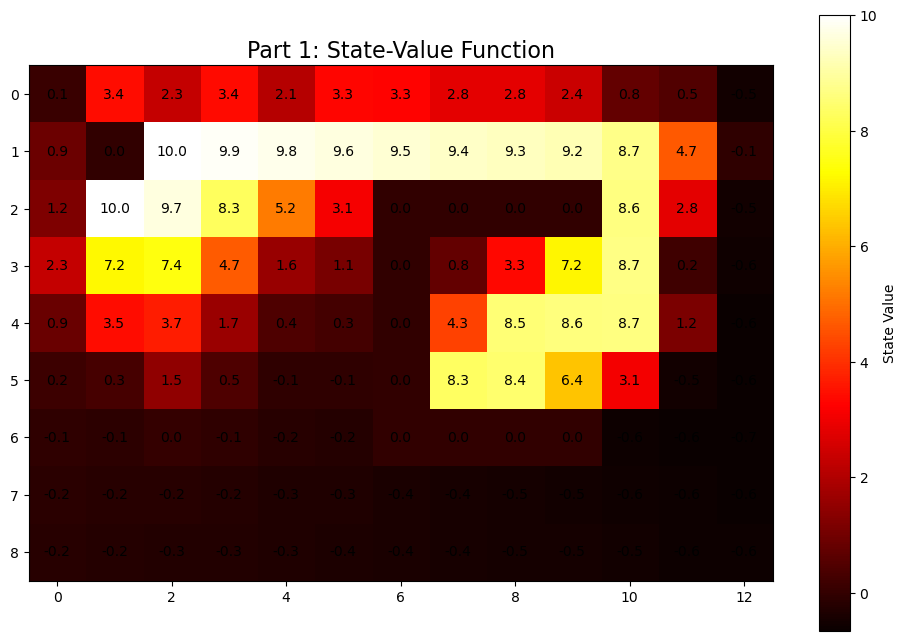

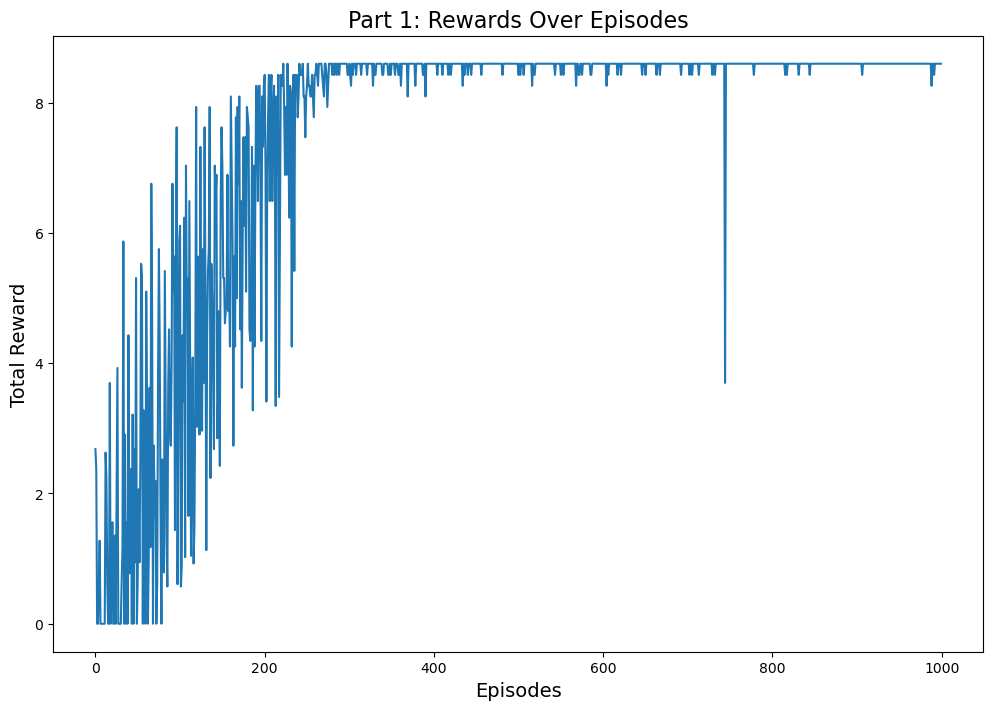

In [7]:
# Define state representation as identity matrix (one-hot encoding)
n_states = maze.size
state_representation = np.eye(n_states)

# Train the actor-critic algorithm
M, V, earned_rewards, _ = actor_critic(state_representation, n_steps=300, alpha=0.1, gamma=0.99, n_episodes=1000)

# Plot state-value function
plt.figure(figsize=(12,8))  # Increase figure size
im = plt.imshow(V.reshape(maze.shape), cmap='hot', alpha=1)  # Reshape V to match maze shape
plt.colorbar(im, label="State Value")
plt.title("Part 1: State-Value Function", fontsize=16)  # Optional: Increase title font size

# Add state value for each heat map field
for (i, j), val in np.ndenumerate(V.reshape(maze.shape)):
    plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black', fontsize=10)  # Optional: Adjust text size

plt.show()

# Plot rewards earned over episodes
plt.figure(figsize=(12,8))  # Increase figure size
plt.plot(earned_rewards)
plt.xlabel("Episodes", fontsize=14)  # Optional: Adjust label font size
plt.ylabel("Total Reward", fontsize=14)  # Optional: Adjust label font size
plt.title("Part 1: Rewards Over Episodes", fontsize=16)  # Optional: Increase title font size
plt.show()


### **Interpretation of the Evolution of Reward Acquisition for Task 1**

#### **Plot Description**  

The trajectory represents the total reward gained in a single episode over the course of learning across 1000 episodes. 

1. **Initial Fluctuations:**  
   At the beginning of training, the rewards fluctuate significantly. This variation depends on the number of steps taken to reach the goal state. The reward is discounted based on the formula:  

   $$R_{\text{discounted}} = r \cdot \gamma^{\text{steps}}$$
 
   - r is the immediate reward upon reaching the goal,  
   - gamma is the discount factor (0 < gamma < 1),  
   - steps is the number of actions taken to reach the goal.  

   The longer the trajectory (i.e., the more actions required), the greater the discounting, resulting in a lower total reward.

2. **Stable Learning Phase (~Episode 300 onwards):**  
   Around episode 300, the trajectory to the goal state becomes well-learned. At this stage, the agent almost consistently reaches the goal state within an optimal range of steps. This optimal performance minimizes the discounting effect, leading to stable and higher rewards.  

In summary, the early learning phase is marked by exploration and variability, while the later phase shows exploitation of the learned optimal trajectory to maximize rewards.

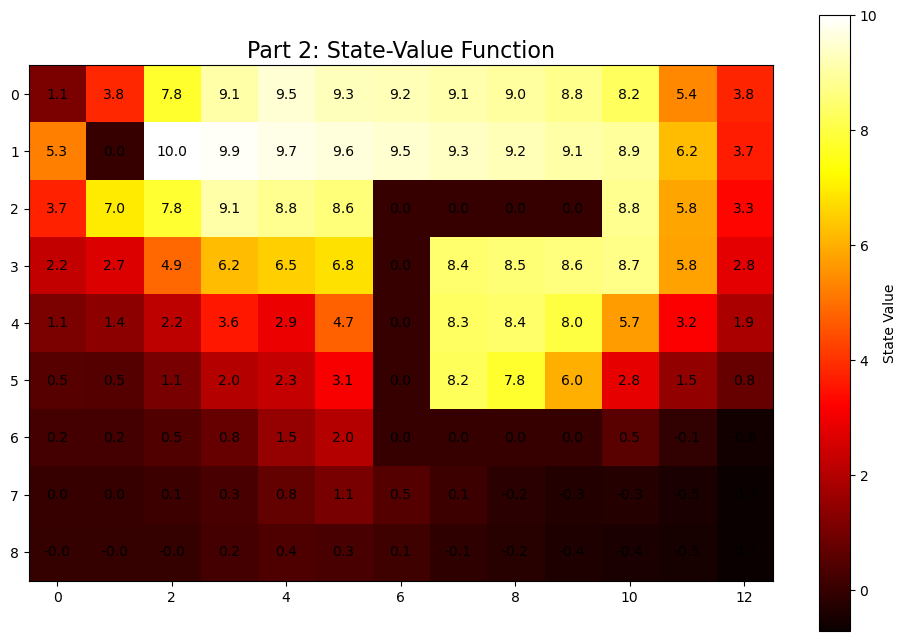

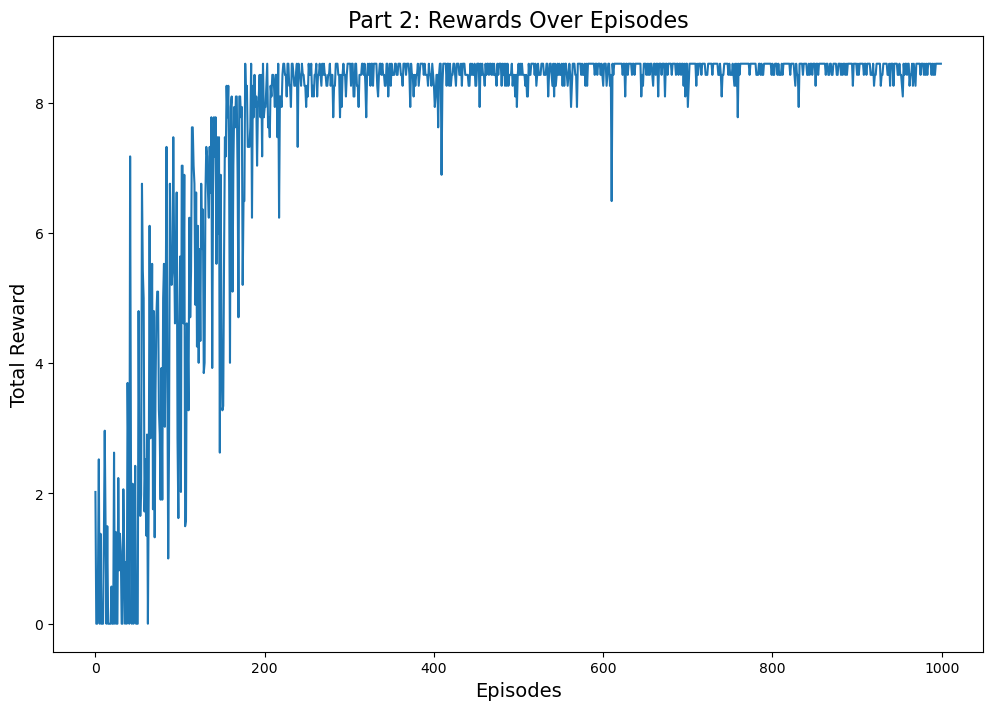

In [12]:
# Part 2, now the same for an SR representation
state_representation = analytical_sr(transitions, 0.8).T  # Compute SR matrix

# Train the actor-critic algorithm
M, V, earned_rewards, _ = actor_critic(state_representation, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000)

# Plot state-value function
plt.figure(figsize=(12,8))  # Increase figure size
im = plt.imshow(V.reshape(maze.shape), cmap='hot', alpha=1)  # Reshape V to match maze shape
plt.colorbar(im, label="State Value")
plt.title("Part 2: State-Value Function", fontsize=16)  # Optional: Increase title font size

# Add state value for each heat map field
for (i, j), val in np.ndenumerate(V.reshape(maze.shape)):
    plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black', fontsize=10)  # Optional: Adjust text size

plt.show()

# Plot rewards earned over episodes
plt.figure(figsize=(12,8))  # Increase figure size
plt.plot(earned_rewards)
plt.xlabel("Episodes", fontsize=14)  # Optional: Adjust label font size
plt.ylabel("Total Reward", fontsize=14)  # Optional: Adjust label font size
plt.title("Part 2: Rewards Over Episodes", fontsize=16)  # Optional: Increase title font size
plt.show()



### **Using the Successor Representation (SR) to Improve Learning Speed for Task 2**

The successor representation (SR) provides a more structured and predictive state representation, enabling faster and more efficient learning compared to the standard actor-critic approach. By incorporating the SR, the agent leverages prior knowledge of the environment's dynamics, resulting in improved policy optimization and reward acquisition.

#### **Plot Description**  
- **Value Function Plot:**  
   The first plot illustrates the learned value function overlayed onto the maze. States closer to the goal state exhibit higher values, and the broader trajectory indicates that the SR encourages more exploration of alternative paths while still optimizing towards the goal.  

- **Reward vs. Episodes Plot:**  
   The second plot shows the rewards acquired over episodes. Initially, there are strong fluctuations as the agent explores the environment, followed by rapid convergence around episode 200. Once the trajectory is learned, the agent nearly consistently exploits the optimal path, leading to stable and higher rewards.

#### **Observations**
1. **Faster Convergence:**  
   Compared to Task 1, the reward trajectory stabilizes significantly faster. This demonstrates that SR-based learning is more efficient in learning an optimal trajectory.

2. **Higher Initial Performance:**  
   The agent begins with a more structured understanding of the environment due to the precomputed SR, resulting in higher initial performance compared to the baseline actor-critic method.

3. **More Explorative Learning Trajectory:**  
   Interestingly, the SR-based approach facilitates a broader exploration of the state space, which is reflected in the value function plot and the early fluctuations in the reward trajectory. This suggests that SR not only aids in faster learning but also in understanding alternative paths to the goal.

#### **Explanation**  
The SR encodes the expected future state visitation for each state under a random policy, allowing the agent to effectively predict long-term rewards. Using the value function.The agent combines the precomputed SR to quickly evaluate state values. This pre-acquired environmental knowledge accelerates learning by reducing dependence on trial-and-error exploration, as seen in Task 1. Moreover, SR-based learning balances exploration and exploitation more effectively, resulting in a faster and broader policy.


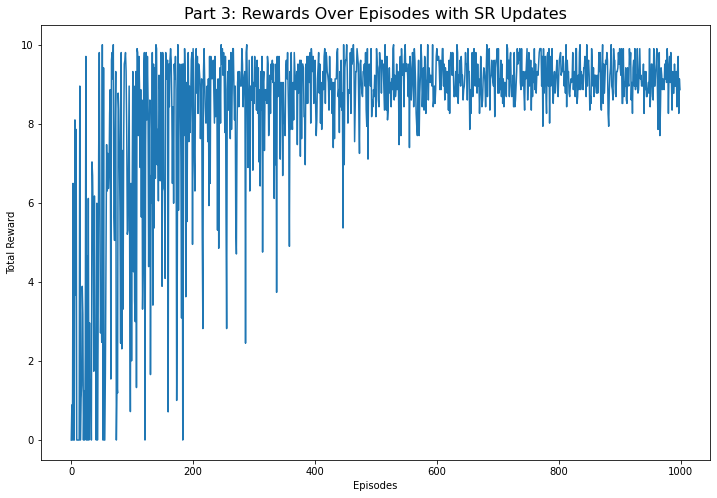

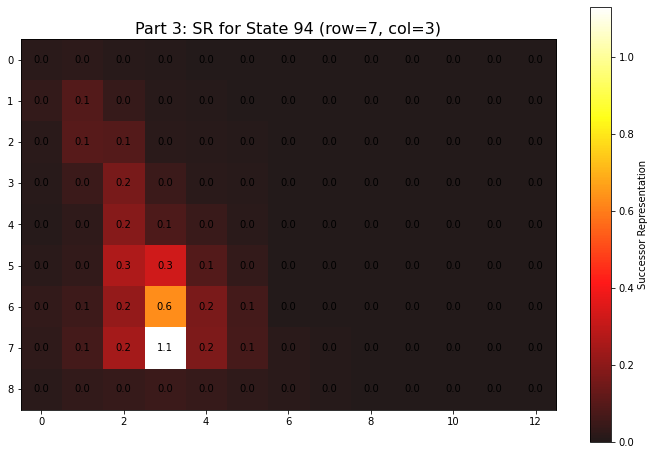

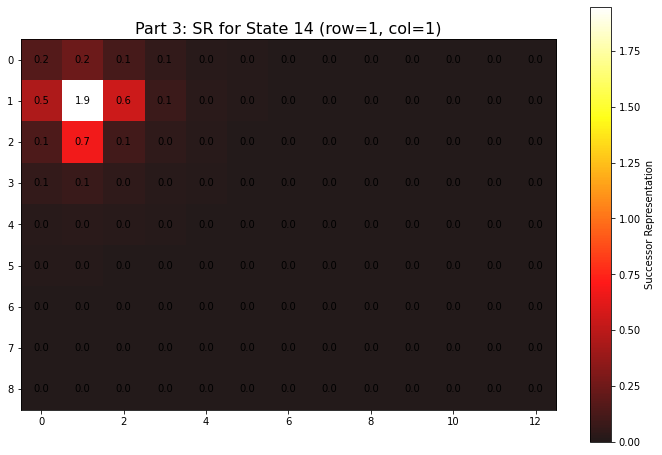

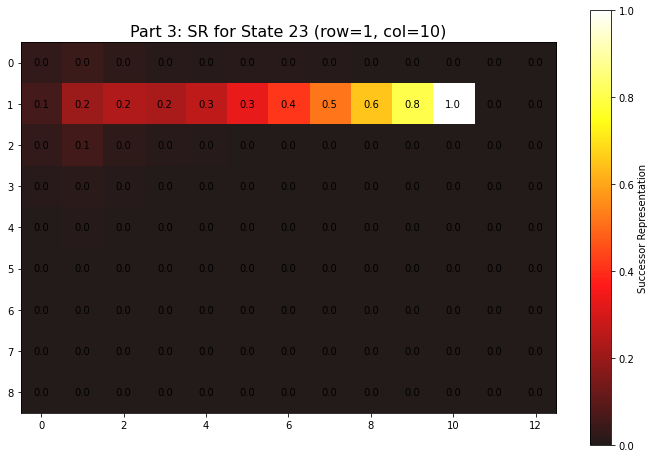

In [62]:
# Part 3
def random_start():
    # define yourself a function to return a random (non-wall) starting state to pass into the actor_critic function
    return np.random.choice(np.where(maze.flatten() == 0)[0])

# Run the actor-critic algorithm with random start and SR updates
state_representation = analytical_sr(transitions, 0.8).T
M, V, earned_rewards, updated_sr = actor_critic( state_representation, 
    n_steps=300, 
    alpha=0.05, 
    gamma=0.99, 
    n_episodes=1000, 
    update_sr=True, 
    start_func=random_start
)

# Plot rewards over episodes
plt.figure(figsize=(12, 8))
plt.plot(earned_rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Part 3: Rewards Over Episodes with SR Updates", fontsize=16)
plt.show()

# Plot SR for random start, goal state and another random start state
for state in [random_start(), goal_state, random_start()]:
    plt.figure(figsize=(12, 8))
    plt.imshow(updated_sr[state].reshape(maze.shape), cmap='hot', alpha=0.9)
    plt.colorbar(label="Successor Representation")
    plt.title(f"Part 3: SR for State {state} (row={state // maze.shape[1]}, col={state % maze.shape[1]})", fontsize=16)
    
    # Add state value for each heat map field
    for (i, j), val in np.ndenumerate(updated_sr[state].reshape(maze.shape)):
        plt.text(j, i, f'{val:.1f}', ha='center', va='center', color='black', fontsize=10)  # Optional: Adjust text size

    plt.show()

### **Studying the Effects of Re-learning the Successor Representation (SR) While Learning the Policy for Task 3**

#### **Plot Description**  
- **Value Function Plots:**  
   For the different gaol states in the maze, we observe that the trajectory from the starting position to the goal state has smoothly increasing values with the highest value being the gaol state. This is a difference to the previous tasks in which the goal state has not been updated.

- **Reward vs. Episodes Plot:**  
   This plot shows the rewards acquired over episodes. Initially, there are even stronger fluctuations as the agent explores the environment, followed by convergence around episode 400. However, due to the different goal states during the training, the fluctuations in the gained reward remain substantial even after convergence.


#### **Observations**
1. **Adaptive SR Specialization:**  
   The SR evolves over time to reflect the learned policy, focusing on states and transitions relevant to optimal trajectories. This leads to a more policy-aligned SR compared to a precomputed SR under a random policy.
   
2. **Improved Policy Refinement:**  
   Dynamic SR updates enhance the agent’s ability to refine its value estimation and policy, particularly in less frequently visited parts of the maze.

3. **Localized SR Patterns:**  
   Plots of SR for selected states demonstrate higher weights for states along the learned optimal paths, showcasing specialization to the policy.

#### **Explanation**
Re-learning the SR allows the agent to focus on transitions relevant to the current policy rather than relying on precomputed, generic SRs. Updating the SR dynamically helps the agent adapt to changes in the policy as it learns, leading to more efficient value function and policy refinement. This is especially useful in environments with complex dynamics or sparse rewards which is not exactly the case in the current setup.

100%|██████████| 20/20 [01:15<00:00,  3.78s/it]


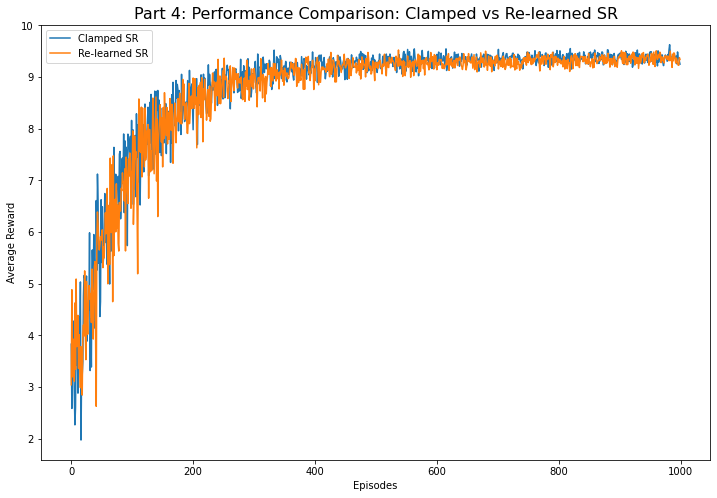

In [53]:
# Part 4

# initialize lists to store rewards for both learners
rewards_clamped = [] 
rewards_relearned = []

goal = (5, 5)
goal_state = goal[0]*maze.shape[1] + goal[1]

for i in tqdm(range(20)):
    # Run actor-critic with the clamped SR (original SR from random walk policy)
    M_clamped, V_clamped, earned_rewards_clamped, _ = actor_critic(
        state_representation=analytical_sr(transitions, 0.8).T,  # clamped SR
        n_steps=300,
        alpha=0.05,
        gamma=0.99,
        n_episodes=1000,
        update_sr=False,  # Don't update SR here, use the original (clamped)
        start_func=random_start
    )
    rewards_clamped.append(earned_rewards_clamped)

    # Run actor-critic with the re-learned SR (learned SR from the earlier tuning towards (1, 1))
    M_relearned, V_relearned, earned_rewards_relearned, _ = actor_critic(
        state_representation=state_representation,  # re-learned SR from prior experiments
        n_steps=300,
        alpha=0.05,
        gamma=0.99,
        n_episodes=1000,
        update_sr=False,  # Don't update SR here, using the already learned SR
        start_func=random_start
    )
    rewards_relearned.append(earned_rewards_relearned)

# Plot the performance averages of the two types of learners
rewards_clamped = np.array(rewards_clamped)
rewards_relearned = np.array(rewards_relearned)

# Plot the average rewards over the 1000 episodes for both learners
plt.figure(figsize=(12,8))
plt.plot(np.mean(rewards_clamped, axis=0), label='Clamped SR')
plt.plot(np.mean(rewards_relearned, axis=0), label='Re-learned SR')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Part 4: Performance Comparison: Clamped vs Re-learned SR', fontsize=16)
plt.legend()
plt.show()


### **Comparing Re-learning with clamped Successor Representation for Task 4**

#### **Plot Description**

- **What do you see?**  
  The plots of state representations (clamped and re-learned) reveal steep improvement within the first 200 episodes, resulting in a rapid increase in the average reward. From episode 400 onwards, the improvement becomes subtle, indicating diminishing returns as the agent converges towards an optimal policy.  

- **How does a re-learned SR affect future policy changes?**  
  While the differences between clamped and re-learned SRs are subtle, the clamped SR appears to learn slightly faster and achieves a marginally more accurate representation.  

- **How do you explain this?**  
  A precomputed (clamped) SR benefits from leveraging prior knowledge, providing a stable and accurate state representation that accelerates initial learning. However, re-learning the SR allows the agent to adapt the state representation dynamically, which can be beneficial in environments where policies evolve or need fine-tuning. This adaptability comes at the cost of slightly slower initial learning due to the additional updates required.  

100%|██████████| 12/12 [01:21<00:00,  6.82s/it]


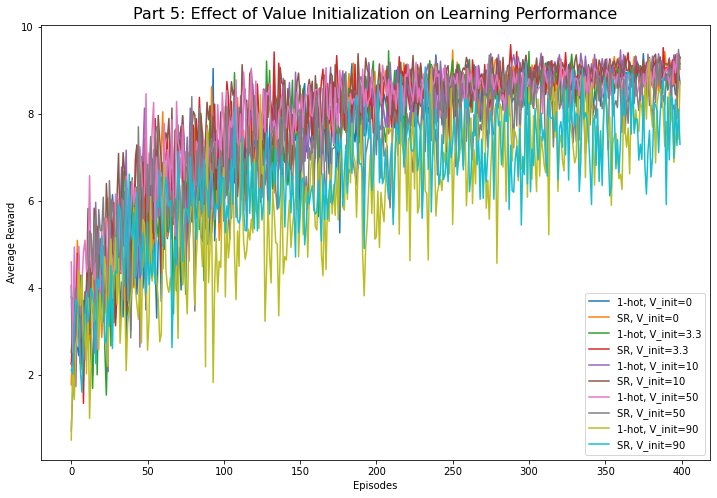

In [61]:
# Part 5

# reset goal
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]

# run some learners with different value weight w initializations
v_inits = [0, 3.3, 10, 50, 90] 
results = {}

for v_init in v_inits:
    earned_rewards_1hot = []  # Store rewards using 1-hot state representation
    earned_rewards_sr = []    # Store rewards using SR state representation

    for _ in tqdm(range(12)):  

        # Run actor-critic with 1-hot representation (using fixed random-walk SR)
        M_1hot, V_1hot, earned_rewards_1hot_run, _ = actor_critic(
            state_representation=analytical_sr(transitions, 0.8).T,  
            n_steps=300,
            alpha=0.05,
            gamma=0.99,
            n_episodes=400,  
            update_sr=False,  
            start_func=random_start,
            v_init=v_init  
        )
        earned_rewards_1hot.append(earned_rewards_1hot_run)

        # Run actor-critic with SR representation
        M_sr, V_sr, earned_rewards_sr_run, _ = actor_critic(
            state_representation=state_representation, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=400, update_sr=True, start_func=random_start, v_init=v_init  # Initialize V with the current value
        )
        earned_rewards_sr.append(earned_rewards_sr_run)

    # Store the average rewards for both representations (1-hot and SR) for the current initialization
    results[v_init] = (np.mean(earned_rewards_1hot, axis=0), np.mean(earned_rewards_sr, axis=0))


# Plot the learning curves for different initializations
plt.figure(figsize=(12,8))

for v_init, (earned_rewards_1hot, earned_rewards_sr) in results.items():
    plt.plot(earned_rewards_1hot, label=f'1-hot, V_init={v_init}')
    plt.plot(earned_rewards_sr, label=f'SR, V_init={v_init}')

plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Part 5: Effect of Value Initialization on Learning Performance', fontsize=16)
plt.legend()
plt.show()

### **Changing the Initial Parameters for Task 5**

#### **Plot Description**

- **What do you see?**  
  The plot shows that while the differences between low and high initialization values are not drastically clear, there is a noticeable trend where initialization values around 90 result in the lowest performance. In contrast, lower initialization values tend to lead to better performance, especially in the early episodes.

- **Why do you think some values help while others hurt?**  
  The initialization of weights plays a critical role in how the agent begins to evaluate and update its policy. When the weights are initialized too high (around 90), the agent may start with overly optimistic estimates of state values, leading to premature exploitation of suboptimal paths. This can hinder exploration, causing the agent to get stuck in local optima early on.  

  On the other hand, lower initialization values (closer to 0) allow the agent to start with more neutral or pessimistic value estimates, encouraging it to explore more and avoid overfitting to early trajectories. This can help the agent learn the optimal policy through more balanced exploration and exploitation. Additionally, lower initial values may provide smoother updates to the policy, enabling better convergence over time.

  In summary, the key factor is finding an initialization value that promotes exploration without causing the agent to settle too quickly on suboptimal solutions. Values that are too high may lead to a lack of exploration, while values that are too low may result in slower convergence or overly cautious behavior.
